In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
#Change Directory
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Python/Use-Case/Customer Clustering/')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Python/Use-Case/Customer Clustering'

In [58]:
# Show Data Profile
def show_data_profile(df):
  Data_dict = pd.DataFrame(df.dtypes)
  Data_dict = Data_dict.rename(columns={0: 'Data_Type'})
  Data_dict['Missing'] = df.isnull().sum()
  Data_dict['Missing_Pct'] = round((df.isnull().sum()/df.count())*100, 2)
  Data_dict['Unique'] = df.nunique()
  Data_dict['Count'] = df.count()
  Data_dict=Data_dict.reset_index()
  desc = df.describe(include='all').T
  desc = desc.drop(['count', 'unique'], axis=1)
  desc = desc.reset_index()
  Data_dict2 = pd.merge(Data_dict,desc,how='left', on=['index'])
  Data_dict2 = Data_dict2.fillna('-')#.sort_values(by=['Data_Type','Missing_Pct'],ascending=[True,False])
  Data_dict2 = Data_dict2.reset_index(drop=True).rename(columns={'index':'Features'})
  return Data_dict2

In [59]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)


import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('mode.chained_assignment', None)

import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns



#DATA PREPARATION

In [60]:
#Load Data
df = pd.read_csv("online-retail-dataset.csv", sep=",",encoding='latin1',dtype={'CustomerID': str} )

In [61]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


**Attribute Information:**

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  

**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  

**Description**: Product (item) name. Nominal.  

**Quantity**: The quantities of each product (item) per transaction. Numeric.  

**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.  

**UnitPrice**: Unit price. Numeric, Product price per unit in sterling.  

**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  

**Country**: Country name. Nominal, the name of the country where each customer resides.

In [62]:
#Rename column replacing whitespace with underscore
df.rename(columns= lambda x : x.replace(' ','_') if ' ' in x else x, inplace=True)
#Remove row with all columns are NA
df = df.dropna(how='all')

In [63]:
show_data_profile(df)

,Features,Data_Type,Missing,Missing_Pct,Unique,Count,top,freq,mean,std,min,25%,50%,75%,max
0,InvoiceNo,object,0,0.00,25900,541909,573585,1114,-,-,-,-,-,-,-
1,StockCode,object,0,0.00,4070,541909,85123A,2313,-,-,-,-,-,-,-
2,Description,object,1454,0.27,4223,540455,WHITE HANGING HEART T-LIGHT HOLDER,2369,-,-,-,-,-,-,-
3,Quantity,int64,0,0.00,722,541909,-,-,9.55225,218.081,-80995,1,3,10,80995
4,InvoiceDate,object,0,0.00,23260,541909,10/31/2011 14:41,1114,-,-,-,-,-,-,-
5,UnitPrice,float64,0,0.00,1630,541909,-,-,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
6,CustomerID,object,135080,33.20,4372,406829,17841,7983,-,-,-,-,-,-,-
7,Country,object,0,0.00,38,541909,United Kingdom,495478,-,-,-,-,-,-,-


In [64]:
#Convert datetime column to datetime format
from datetime import datetime
df['InvoiceDate'] = df['InvoiceDate'].apply(lambda x:  datetime.strptime(x, '%m/%d/%Y %H:%M'))

In [65]:
#Split column to alphabet and numeric
df['Status']=df['InvoiceNo'].apply(lambda x : ''.join(re.findall(r"[a-zA-Z]",str(x))))
df['Status']=df['Status'].replace('','S')
df['InvoiceNo']=df['InvoiceNo'].apply(lambda x : ''.join(re.findall(r"\d+",str(x))))

In [66]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,S
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,S
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,S


In [67]:
df['Status'].unique()

array(['S', 'C', 'A'], dtype=object)

In [68]:
dF = df[df['Status']=='S']

## Feature Engineering

In [69]:
#Add Revenue column
df['Revenue']=df['Quantity']*df['UnitPrice']

In [70]:
#Add splitted datetime column
df['yearmonth']=df['InvoiceDate'].dt.strftime('%Y%m')
df['year']=df['InvoiceDate'].dt.strftime('%Y')
df['month']=df['InvoiceDate'].dt.strftime('%m')
df['date']=df['InvoiceDate'].dt.strftime('%d')
df['hour']=df['InvoiceDate'].dt.strftime('%H')
df['dayofweek']=df['InvoiceDate'].dt.strftime('%w') 
df['indexofweek']=(df['InvoiceDate'].dt.day - 1) // 7 + 1 #Index of week in a month (1-5)
df['quarter']=df['InvoiceDate'].dt.quarter # 1 = Jan-Mar, 2 = Apr-Jun, dst


In [71]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,Revenue,yearmonth,year,month,date,hour,dayofweek,indexofweek,quarter
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,S,15.30,201012,2010,12,01,08,3,1,4
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,S,20.34,201012,2010,12,01,08,3,1,4
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,S,22.00,201012,2010,12,01,08,3,1,4


In [72]:
#Convert data type
df['month']=df['month'].astype(int)
df['date']=df['date'].astype(int)
df['hour']=df['hour'].astype(int)
df['dayofweek']=df['dayofweek'].astype(int)


In [73]:
#Add first transaction
df['First_InvoiceDate']=df.groupby('CustomerID')['InvoiceDate'].transform(min)
#Add last transaction
df['Last_InvoiceDate']=df.groupby('CustomerID')['InvoiceDate'].transform(max)

In [74]:
#Add num of days between current and first trx
df['days_current_first'] = (df['InvoiceDate']-df['First_InvoiceDate']).dt.days

In [75]:
#Add num of days between last and first trx
df['days_last_first'] = (df['Last_InvoiceDate']-df['First_InvoiceDate']).dt.days

In [76]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,Revenue,yearmonth,year,month,date,hour,dayofweek,indexofweek,quarter,First_InvoiceDate,Last_InvoiceDate,days_current_first,days_last_first
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,S,15.30,201012,2010,12,1,8,3,1,4,2010-12-01 08:26:00,2011-02-10 14:38:00,0.0,71.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,S,20.34,201012,2010,12,1,8,3,1,4,2010-12-01 08:26:00,2011-02-10 14:38:00,0.0,71.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,S,22.00,201012,2010,12,1,8,3,1,4,2010-12-01 08:26:00,2011-02-10 14:38:00,0.0,71.0


In [77]:
show_data_profile(df)

,Features,Data_Type,Missing,Missing_Pct,Unique,Count,top,freq,first,last,mean,std,min,25%,50%,75%,max
0,InvoiceNo,object,0,0.00,25900,541909,573585,1114,-,-,-,-,-,-,-,-,-
1,StockCode,object,0,0.00,4070,541909,85123A,2313,-,-,-,-,-,-,-,-,-
2,Description,object,1454,0.27,4223,540455,WHITE HANGING HEART T-LIGHT HOLDER,2369,-,-,-,-,-,-,-,-,-
3,Quantity,int64,0,0.00,722,541909,-,-,-,-,9.55225,218.081,-80995,1,3,10,80995
4,InvoiceDate,datetime64[ns],0,0.00,23260,541909,2011-10-31 14:41:00,1114,2010-12-01 08:26:00,2011-12-09 12:50:00,-,-,-,-,-,-,-
5,UnitPrice,float64,0,0.00,1630,541909,-,-,-,-,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
6,CustomerID,object,135080,33.20,4372,406829,17841,7983,-,-,-,-,-,-,-,-,-
7,Country,object,0,0.00,38,541909,United Kingdom,495478,-,-,-,-,-,-,-,-,-
8,Status,object,0,0.00,3,541909,S,532618,-,-,-,-,-,-,-,-,-
9,Revenue,float64,0,0.00,6204,541909,-,-,-,-,17.9878,378.811,-168470,3.4,9.75,17.4,168470


## Data Cleaning

In [78]:
#Remove row with CustomerID=NA
df = df[~df['CustomerID'].isna()]
df['Description'] = df['Description'].fillna('')

In [79]:
#Remove row with Negative Quantity
df = df[df['Quantity'] >0]

In [80]:
show_data_profile(df)

,Features,Data_Type,Missing,Missing_Pct,Unique,Count,top,freq,first,last,mean,std,min,25%,50%,75%,max
0,InvoiceNo,object,0,0.0,18536,397924,576339,542,-,-,-,-,-,-,-,-,-
1,StockCode,object,0,0.0,3665,397924,85123A,2035,-,-,-,-,-,-,-,-,-
2,Description,object,0,0.0,3877,397924,WHITE HANGING HEART T-LIGHT HOLDER,2028,-,-,-,-,-,-,-,-,-
3,Quantity,int64,0,0.0,302,397924,-,-,-,-,13.0218,180.42,1,2,6,12,80995
4,InvoiceDate,datetime64[ns],0,0.0,17286,397924,2011-11-14 15:27:00,542,2010-12-01 08:26:00,2011-12-09 12:50:00,-,-,-,-,-,-,-
5,UnitPrice,float64,0,0.0,441,397924,-,-,-,-,3.11617,22.0968,0,1.25,1.95,3.75,8142.75
6,CustomerID,object,0,0.0,4339,397924,17841,7847,-,-,-,-,-,-,-,-,-
7,Country,object,0,0.0,37,397924,United Kingdom,354345,-,-,-,-,-,-,-,-,-
8,Status,object,0,0.0,1,397924,S,397924,-,-,-,-,-,-,-,-,-
9,Revenue,float64,0,0.0,2940,397924,-,-,-,-,22.3947,309.056,0,4.68,11.8,19.8,168470


## Transaction aggregation by customerID

In [81]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,Revenue,yearmonth,year,month,date,hour,dayofweek,indexofweek,quarter,First_InvoiceDate,Last_InvoiceDate,days_current_first,days_last_first
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,S,15.3,201012,2010,12,1,8,3,1,4,2010-12-01 08:26:00,2011-02-10 14:38:00,0.0,71.0


In [82]:
max_date=df['InvoiceDate'].max() + pd.to_timedelta(1, unit='d')
max_date

Timestamp('2011-12-10 12:50:00')

In [84]:
df_customer = df.groupby(['CustomerID']).aggregate({'Quantity':sum,'Revenue':sum,'InvoiceNo': pd.Series.nunique,'StockCode': pd.Series.nunique,'InvoiceDate':[min,max],'month':np.mean,'date':np.mean,'hour':np.mean,'dayofweek':np.mean,'indexofweek':np.mean}).reset_index()
df_customer.columns=['CustomerID','Quantity','Revenue','Count_Invoice','Count_StockCode','First_Invoice','Last_Invoice','month'	,'date'	,'hour'	,'dayofweek'	,'indexofweek']
df_customer['diff_last_first']=(df_customer['Last_Invoice']-df_customer['First_Invoice']).dt.days
df_customer['diff_max_last']=(max_date-df_customer['Last_Invoice']).dt.days
df_customer.sort_values(by='Revenue',ascending=False)

,CustomerID,Quantity,Revenue,Count_Invoice,Count_StockCode,First_Invoice,Last_Invoice,month,date,hour,dayofweek,indexofweek,diff_last_first,diff_max_last
1690,14646,197491,280206.02,74,701,2010-12-20 10:09:00,2011-12-08 12:12:00,6.822596,17.246154,11.773077,2.975000,2.788942,353,2
4202,18102,64124,259657.30,60,150,2010-12-07 16:42:00,2011-12-09 11:50:00,8.691415,11.222738,12.962877,2.925754,2.095128,366,1
3729,17450,69993,194550.79,46,124,2010-12-07 09:23:00,2011-12-01 13:29:00,6.801187,17.468843,12.284866,2.498516,2.860534,359,8
3009,16446,80997,168472.50,2,3,2011-05-18 09:52:00,2011-12-09 09:15:00,7.333333,15.000000,9.000000,3.666667,2.666667,204,1
1880,14911,80515,143825.06,201,1787,2010-12-01 14:05:00,2011-12-08 15:54:00,8.141624,15.659679,12.004228,2.828959,2.640831,372,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,17956,1,12.75,1,1,2011-04-04 13:47:00,2011-04-04 13:47:00,4.000000,4.000000,13.000000,1.000000,1.000000,0,249
3015,16454,3,6.90,2,2,2011-10-06 16:57:00,2011-10-26 11:40:00,10.000000,16.000000,13.500000,3.500000,2.500000,19,45
1794,14792,2,6.20,1,2,2011-10-07 09:19:00,2011-10-07 09:19:00,10.000000,7.000000,9.000000,5.000000,1.000000,0,64
3218,16738,3,3.75,1,1,2011-02-15 09:46:00,2011-02-15 09:46:00,2.000000,15.000000,9.000000,2.000000,3.000000,0,298


In [85]:
show_data_profile(df_customer)

,Features,Data_Type,Missing,Missing_Pct,Unique,Count,top,freq,first,last,mean,std,min,25%,50%,75%,max
0,CustomerID,object,0,0.0,4339,4339,17461,1,-,-,-,-,-,-,-,-,-
1,Quantity,int64,0,0.0,1768,4339,-,-,-,-,1194.21,5055.6,1,160,379,993,197491
2,Revenue,float64,0,0.0,4285,4339,-,-,-,-,2053.79,8988.25,0,307.245,674.45,1661.64,280206
3,Count_Invoice,int64,0,0.0,59,4339,-,-,-,-,4.27195,7.70549,1,1,2,5,210
4,Count_StockCode,int64,0,0.0,338,4339,-,-,-,-,61.4893,85.3639,1,16,35,77,1787
5,First_Invoice,datetime64[ns],0,0.0,4241,4339,2010-12-07 15:48:00,3,2010-12-01 08:26:00,2011-12-09 12:16:00,-,-,-,-,-,-,-
6,Last_Invoice,datetime64[ns],0,0.0,4200,4339,2011-12-01 13:47:00,3,2010-12-01 09:53:00,2011-12-09 12:50:00,-,-,-,-,-,-,-
7,month,float64,0,0.0,2308,4339,-,-,-,-,7.52771,2.69728,1,5.91612,7.65385,9.87698,12
8,date,float64,0,0.0,2501,4339,-,-,-,-,15.055,6.68514,1,10.4907,15,19.4373,31
9,hour,float64,0,0.0,2205,4339,-,-,-,-,12.5674,1.91173,7,11.3762,12.4667,13.9235,20


# **CLUSTERING**

## KMeans

### Select Features

In [87]:
X = df_customer.drop(['CustomerID', 'First_Invoice', 'Last_Invoice', 'diff_max_last'],axis='columns')

### Features Standardization / Scaling

In [88]:
# Scaling / Standardization

#MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

# #StandarScaler
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(X)
# scaler.transform(X)
# X = pd.DataFrame(X,columns = X.columns)

X.head(3)

,Quantity,Revenue,Count_Invoice,Count_StockCode,month,date,hour,dayofweek,indexofweek,diff_last_first
0,0.375786,0.275453,0.000000,0.000000,0.000000,0.566667,0.230769,0.400000,0.500000,0.000000
1,0.012441,0.015382,0.028708,0.057111,0.599900,0.493956,0.399408,0.484615,0.402473,0.978552
2,0.011849,0.006414,0.014354,0.011758,0.662757,0.527957,0.632754,0.580645,0.491935,0.756032


### Determine number of K

#### Elbow Method

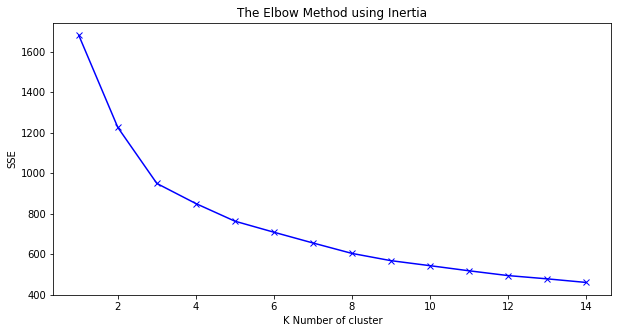

In [89]:
# Elbow Method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
data= X
sse = {} #sum of squared errors
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10,5))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("K Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method using Inertia')
plt.show()

#### Silhouette Score

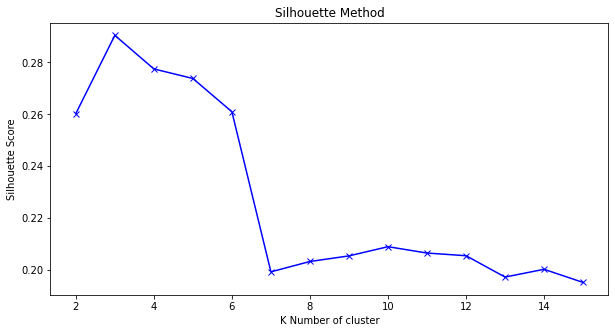

In [90]:
# Silhouette Method
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
data= X
sil = []
kmax = 15
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(data)
  labels = kmeans.labels_
  sil.append([k,silhouette_score(data, labels, metric = 'euclidean')])


df_sil= pd.DataFrame(sil, columns=['K','Silhouette Score'])
plt.figure(figsize=(10,5))
plt.plot(df_sil['K'], df_sil['Silhouette Score'], 'bx-')
plt.xlabel("K Number of cluster")
plt.ylabel("Silhouette Score")
plt.title('Silhouette Method')
plt.show()

In [ ]:
df_sil.head(3)

,K,Silhouette Score
0,2,0.681046
1,3,0.552819
2,4,0.498051


#### Davies Bouldin Index

In [110]:
# Calculate davies_bouldin_score
from sklearn.metrics import davies_bouldin_score 
  
# loading the dataset 
X_dbi = X.iloc[:,:4]
  
# we store the cluster labels 
cluster =  km.labels_ 
  
print(davies_bouldin_score(X, km.labels_)) 

0.6993408749514544


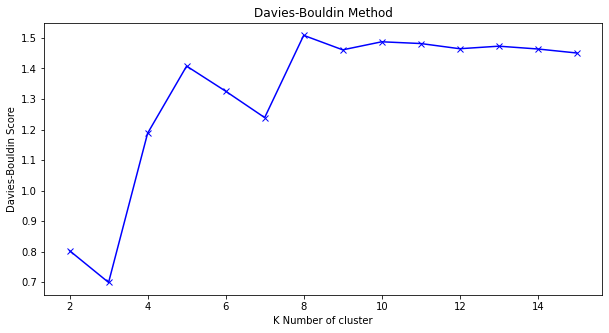

In [111]:
#  Davies-Bouldin Index Method
from sklearn.metrics import davies_bouldin_score
data= X
dbi = []
kmax = 15
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(data)
  labels = kmeans.labels_
  dbi.append([k,davies_bouldin_score(data, labels)])


df_dbi= pd.DataFrame(dbi, columns=['K','Davies-Bouldin Score'])
plt.figure(figsize=(10,5))
plt.plot(df_sil['K'], df_dbi['Davies-Bouldin Score'], 'bx-')
plt.xlabel("K Number of cluster")
plt.ylabel("Davies-Bouldin Score")
plt.title('Davies-Bouldin Method')
plt.show()

### Model Fitting

In [91]:
# Model Fitting
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3, n_jobs = 4, random_state=21)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=4, precompute_distances='auto',
       random_state=21, tol=0.0001, verbose=0)

In [92]:
X['cluster']=km.labels_
X.head(3)

,Quantity,Revenue,Count_Invoice,Count_StockCode,month,date,hour,dayofweek,indexofweek,diff_last_first,cluster
0,0.375786,0.275453,0.000000,0.000000,0.000000,0.566667,0.230769,0.400000,0.500000,0.000000,2
1,0.012441,0.015382,0.028708,0.057111,0.599900,0.493956,0.399408,0.484615,0.402473,0.978552,1
2,0.011849,0.006414,0.014354,0.011758,0.662757,0.527957,0.632754,0.580645,0.491935,0.756032,1


### Evaluation

#### ANOVA F-Statistics

In [95]:
# ANOVA F-statistics

import statsmodels.api as sm
from statsmodels.formula.api import ols

cols = X.columns.tolist()
cols.remove('cluster')

group_var = pd.DataFrame()
for col in cols : 
    lm = ols(col+' ~ C(cluster)', data = X).fit()
    table=sm.stats.anova_lm(lm)
    table = table.iloc[0,:].reset_index().set_index('index').T
    feature = pd.DataFrame({'Feature':[col]})
    x = pd.concat([table.reset_index(),feature], axis='columns')
    group_var =pd.concat([group_var,x], axis='rows')
    
group_var = group_var.iloc[:,np.r_[6,1:6]]
group_var.sort_values(by='F', ascending=False)

,Feature,df,sum_sq,mean_sq,F,PR(>F)
0,diff_last_first,2.0,439.786310,219.893155,9184.515040,0.000000e+00
0,indexofweek,2.0,153.742548,76.871274,3466.320109,0.000000e+00
0,date,2.0,130.871626,65.435813,3356.186684,0.000000e+00
0,Count_Invoice,2.0,0.900163,0.450081,390.592969,1.071293e-156
0,Count_StockCode,2.0,1.478584,0.739292,380.191903,7.332527e-153
0,Quantity,2.0,0.097684,0.048842,77.148051,1.195054e-33
0,Revenue,2.0,0.146403,0.073201,73.520389,3.980657e-32
0,month,2.0,3.758771,1.879386,31.699523,2.151535e-14
0,dayofweek,2.0,0.832032,0.416016,6.141736,2.169946e-03
0,hour,2.0,0.091316,0.045658,2.112395,1.210724e-01


#### Density Plot

In [93]:
# Density plot
X_melt = X.melt(id_vars=['cluster'])
X_melt.head(3)

,cluster,variable,value
0,2,Quantity,0.375786
1,1,Quantity,0.012441
2,1,Quantity,0.011849


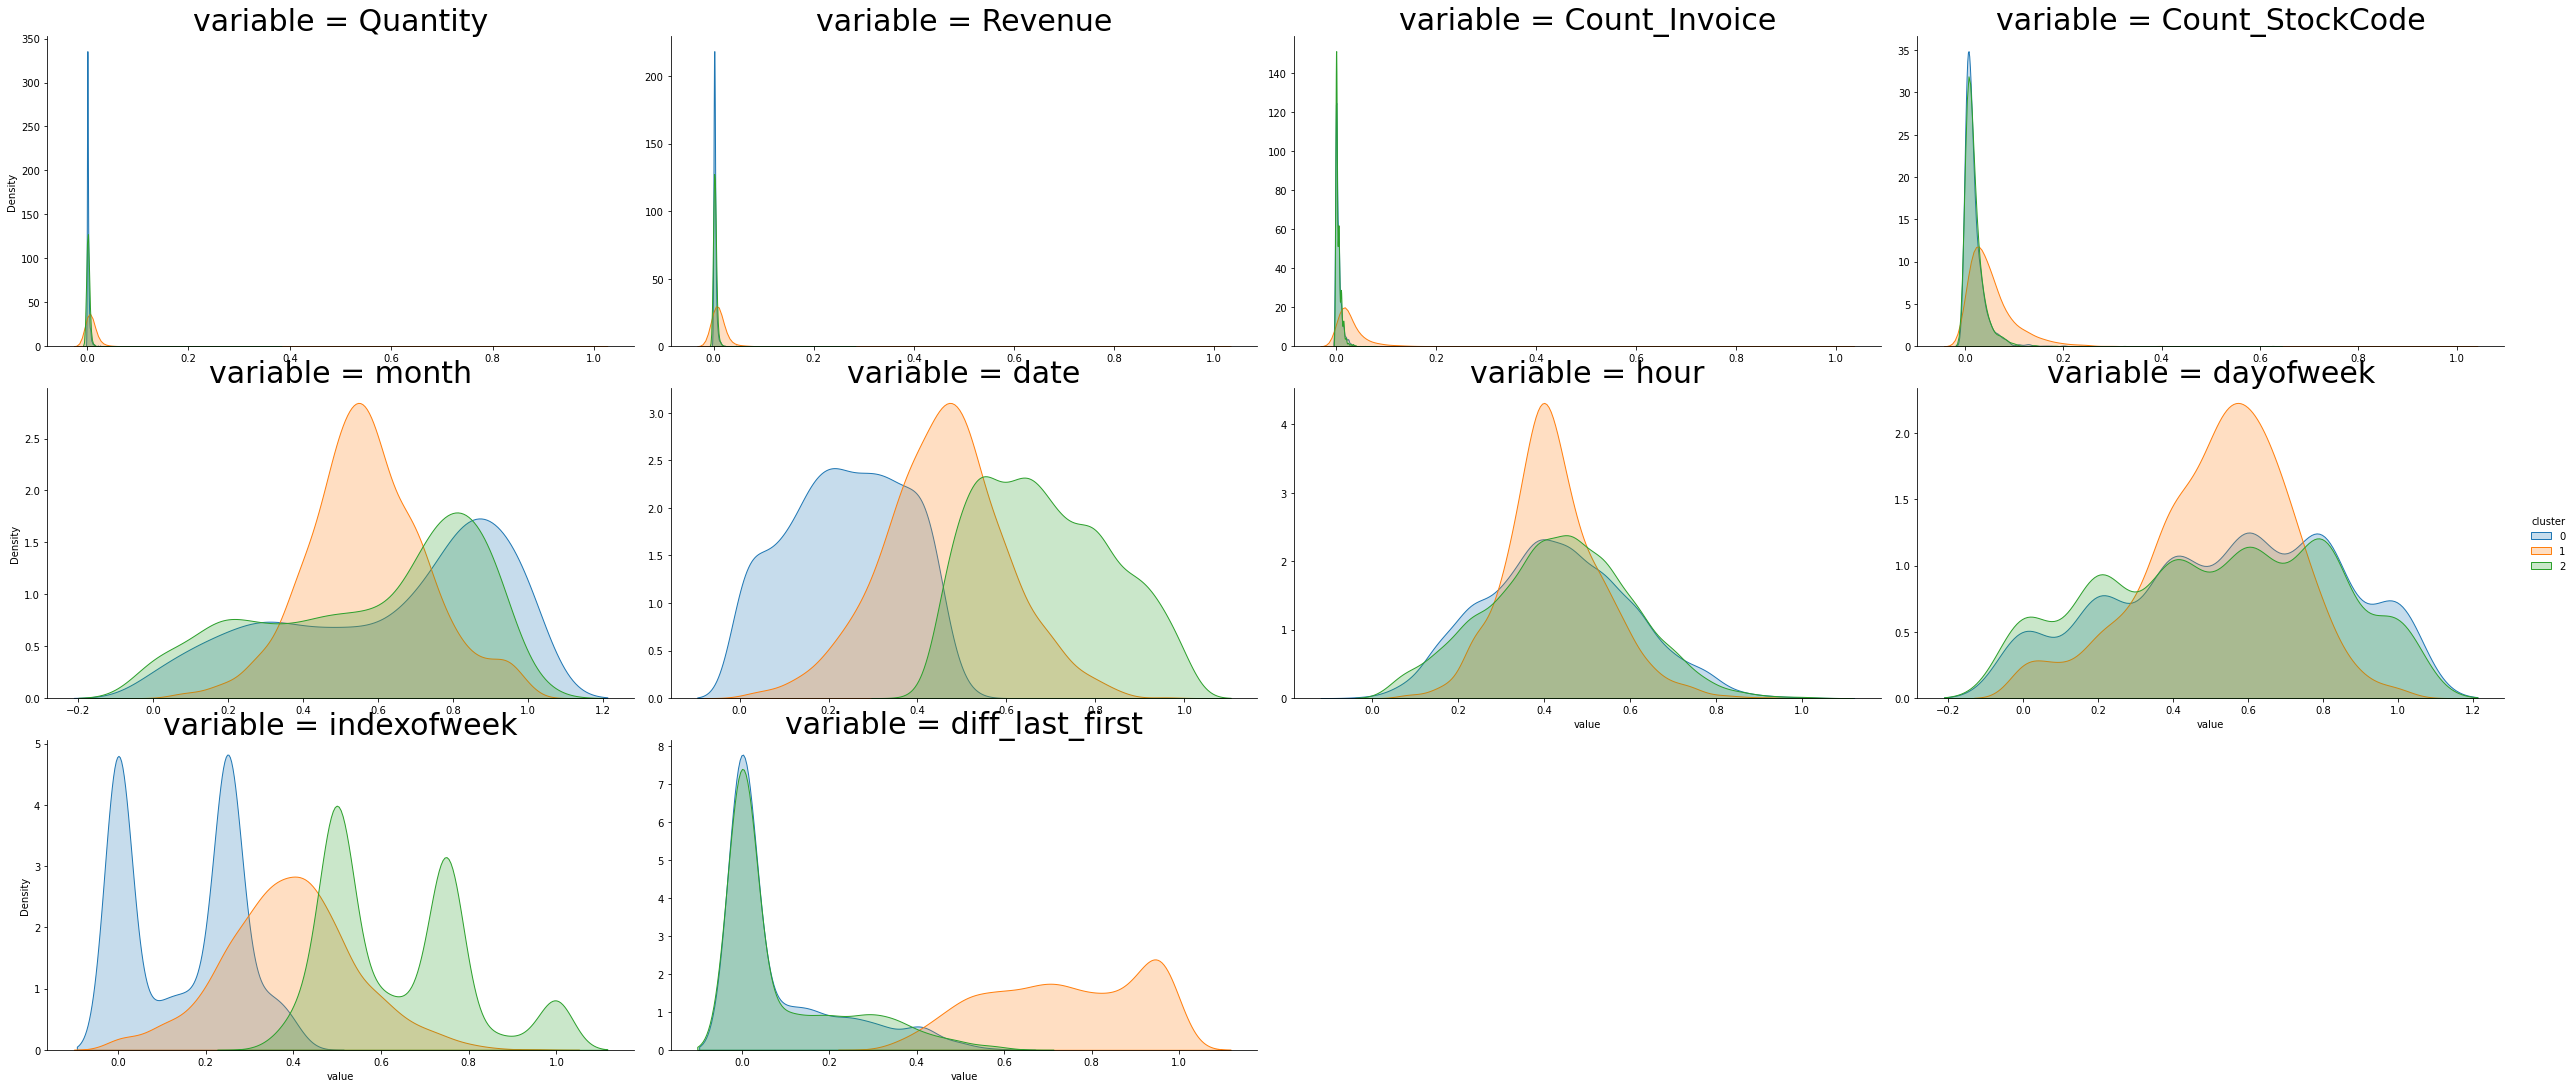

In [94]:
g = sns.FacetGrid(X_melt,height=5, aspect=1.75, col='variable',sharey=False,sharex=False, col_wrap=4,hue='cluster')
g = g.map(sns.kdeplot, "value", shade=True)
g.add_legend(title="cluster")
g.set_xlabels("value")
g.set_ylabels("Density")
g.set_titles(size=30)
g.fig.show()

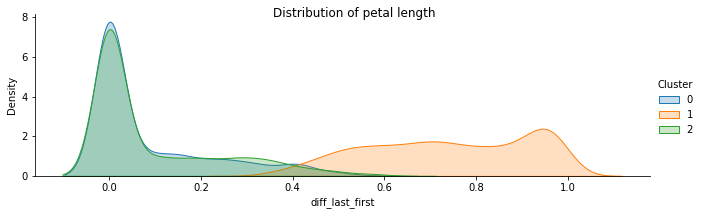

In [96]:
g = sns.FacetGrid(X, hue='cluster',height=3, aspect=3)
g = g.map(sns.kdeplot, "diff_last_first", shade=True)
#plt.xlim(-0.1,10)
g.add_legend(title="Cluster")
g.set_ylabels("Density")
g.fig.suptitle("Distribution of petal length")
g.fig.show()

#### Scatter Plot

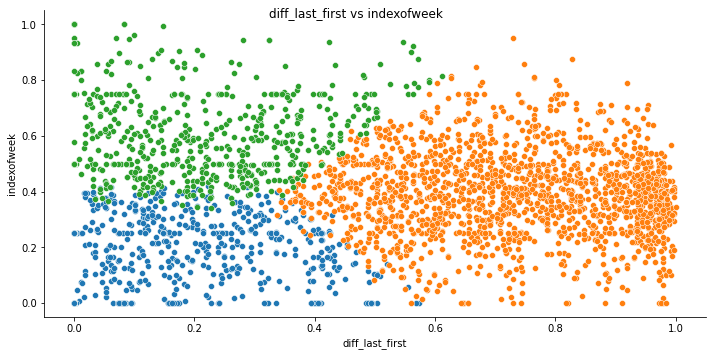

In [97]:
# 2D Plot
g = sns.FacetGrid(X,height=5, aspect=2,hue='cluster')
g = g.map_dataframe(sns.scatterplot ,"diff_last_first",'indexofweek')
#g.set(xticks=range(0,max(df['Engine HP'].dropna().astype(int)),100))
g.fig.suptitle("diff_last_first vs indexofweek")
g.fig.show()

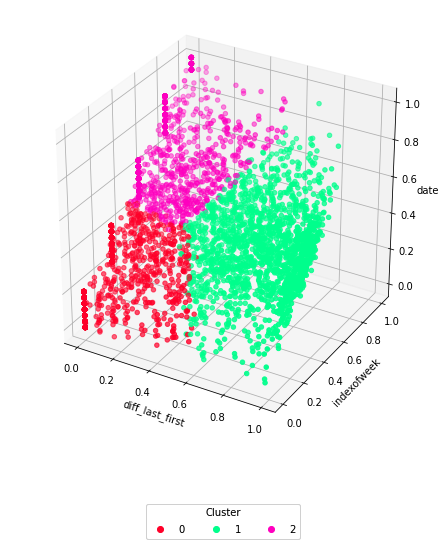

In [98]:
# 3D Plot

from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
%matplotlib inline
#sns.set_style("whitegrid", {'axes.grid' : False})
plt.style.use('seaborn-muted')

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig)

x = X['diff_last_first']
y = X['indexofweek']
z = X['date']
cluster = X['cluster']

g = ax.scatter(x, y, z, c=cluster, marker='o', depthshade=True,cmap='gist_rainbow' ) #cmap='Paired'
ax.set_xlabel('diff_last_first')
ax.set_ylabel('indexofweek')
ax.set_zlabel('date')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*g.legend_elements(), loc="lower center", title="Cluster", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

plt.show()

#### tSNE plot

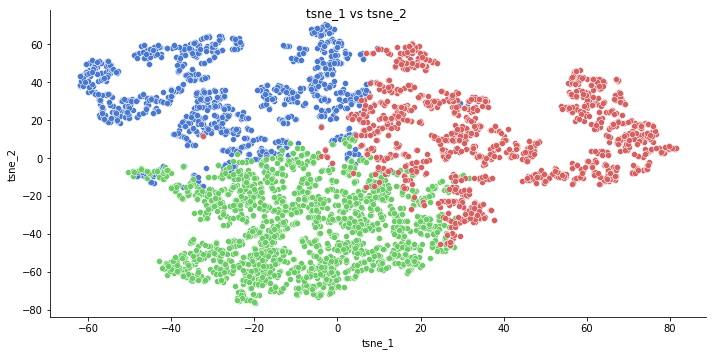

In [99]:
X_tsne = X.drop('cluster', axis='columns')
y_tsne = X['cluster']

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=1000, random_state=123)
X_tsne = tsne.fit_transform(X_tsne)
X_tsne_transformed = pd.DataFrame(X_tsne, columns=['tsne_1','tsne_2'])

df_tsne = pd.concat([X_tsne_transformed,y_tsne], axis='columns')

g = sns.FacetGrid(df_tsne,height=5, aspect=2,hue='cluster')
g = g.map_dataframe(sns.scatterplot ,"tsne_1",'tsne_2')
#g.set(xticks=range(0,max(df['Engine HP'].dropna().astype(int)),100))
g.fig.suptitle("tsne_1 vs tsne_2")
g.fig.show()

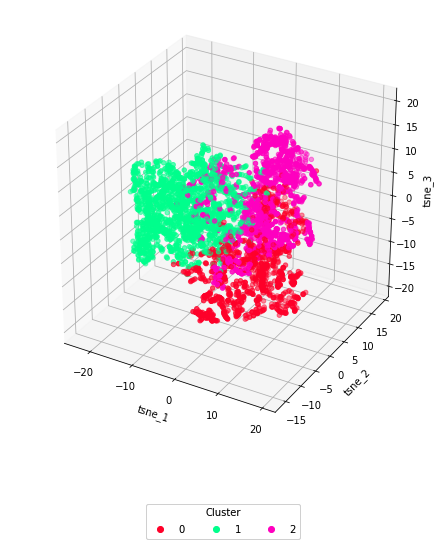

In [100]:
X_tsne = X.drop('cluster', axis='columns')
y_tsne = X['cluster']

from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_iter=1000, random_state=123)
X_tsne = tsne.fit_transform(X_tsne)
X_tsne_transformed = pd.DataFrame(X_tsne, columns=['tsne_1','tsne_2','tsne_3'])

df_tsne = pd.concat([X_tsne_transformed,y_tsne], axis='columns')


from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
%matplotlib inline
#sns.set_style("whitegrid", {'axes.grid' : False})
plt.style.use('seaborn-muted')

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig)

x = df_tsne['tsne_1']
y = df_tsne['tsne_2']
z = df_tsne['tsne_3']
cluster = df_tsne['cluster']

g = ax.scatter(x, y, z, c=cluster, marker='o', depthshade=True,cmap='gist_rainbow' ) #cmap='Paired'
ax.set_xlabel('tsne_1')
ax.set_ylabel('tsne_2')
ax.set_zlabel('tsne_3')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*g.legend_elements(), loc="lower center", title="Cluster", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

plt.show()


# INTERPRETATION

In [105]:
df_customer['cluster'] = km.labels_

In [106]:
df_customer.head(3)

,CustomerID,Quantity,Revenue,Count_Invoice,Count_StockCode,First_Invoice,Last_Invoice,month,date,hour,dayofweek,indexofweek,diff_last_first,diff_max_last,cluster
0,12346,74215,77183.60,1,1,2011-01-18 10:01:00,2011-01-18 10:01:00,1.000000,18.000000,10.000000,2.000000,3.000000,0,326,2
1,12347,2458,4310.00,7,103,2010-12-07 14:57:00,2011-12-07 15:52:00,7.598901,15.818681,12.192308,2.423077,2.609890,365,2,1
2,12348,2341,1797.24,4,22,2010-12-16 19:09:00,2011-09-25 13:13:00,8.290323,16.838710,15.225806,2.903226,2.967742,282,75,1


In [108]:
df_customer_interpret = df_customer.groupby('cluster').aggregate({'Quantity':np.mean,'Revenue':np.mean,'Count_Invoice':np.mean,'Count_StockCode':np.mean,'month':np.mean,'date':np.mean,'hour':np.mean,'dayofweek':np.mean,'indexofweek':np.mean,'diff_last_first':np.mean})

In [109]:
df_customer_interpret

,Quantity,Revenue,Count_Invoice,Count_StockCode,month,date,hour,dayofweek,indexofweek,diff_last_first
cluster,,,,,,,,,,
0,383.589847,671.117939,1.827558,34.277196,8.036011,8.182052,12.590606,2.742453,1.603705,31.845286
1,2339.813003,4044.369857,7.954545,101.821059,7.286036,14.806130,12.497613,2.596212,2.562654,275.683544
2,469.901471,771.643920,1.796324,34.778676,7.372734,21.644608,12.635460,2.581675,3.549327,34.726471


In [114]:
df_customer_interpret.index=['Loyal Customer','Potential 1st week customer','Potential 3rd week customer']

In [115]:
df_customer_interpret

,Quantity,Revenue,Count_Invoice,Count_StockCode,month,date,hour,dayofweek,indexofweek,diff_last_first
Loyal Customer,383.589847,671.117939,1.827558,34.277196,8.036011,8.182052,12.590606,2.742453,1.603705,31.845286
Potential 1st week customer,2339.813003,4044.369857,7.954545,101.821059,7.286036,14.806130,12.497613,2.596212,2.562654,275.683544
Potential 3rd week customer,469.901471,771.643920,1.796324,34.778676,7.372734,21.644608,12.635460,2.581675,3.549327,34.726471
